In [1]:
import plotly.graph_objects as go
import datetime
from datetime import datetime
import random
import calendar
import time
import sklearn
from matplotlib.lines import Line2D
import statsmodels.tsa.stattools as ts
import matplotlib.ticker as mtick
import matplotlib.collections as collections
from numpy import linalg
import os
import sys
import pandas as pd 
import numpy as np
import warnings
from sklearn import datasets
warnings.filterwarnings("ignore")
import math
import operator
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager as fm
from sklearn import preprocessing
from sklearn import linear_model
from statsmodels.tsa.arima_model import ARIMA
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy import stats
from copy import deepcopy
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from datetime import datetime
from WindPy import w
w.start()
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.feature_extraction import DictVectorizer
import csv
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


In [29]:
#趋势划分函数

def ud(data, l1, l2):
    i = 0
    res = [0] * len(data)

    while i < len(data)-1:
        if i + l1 >= len(data) - 1:
            for j in range(i, len(data)):
                res[j] = res[i]
                break
        cur = data[i]
        
        next_id = min([(data).index(max(data[i+1+l1:i+1+l2])), data.index(min(data[i+1+l1:i+1+l2]))])
        res[i:next_id+1] = [- (-1) ** (data[next_id] > data[i])] * (next_id + 1 - i)
        i = next_id
    return res

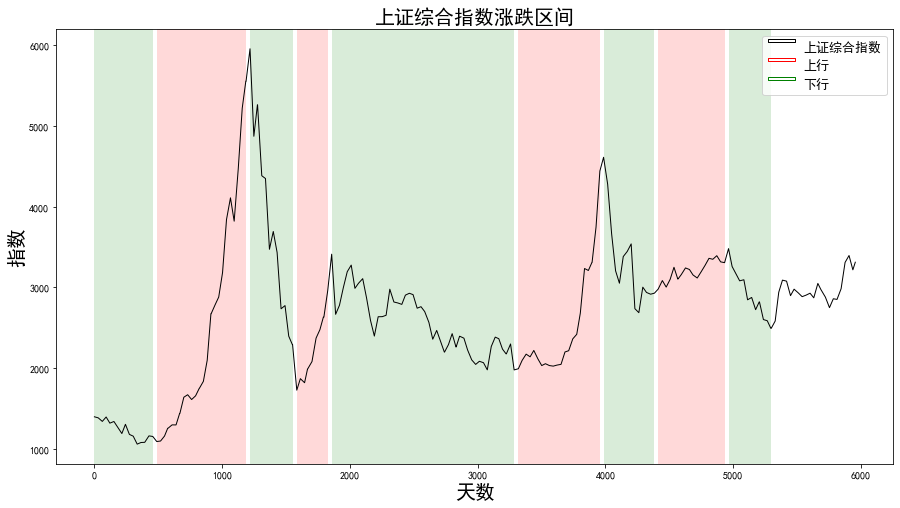

In [4]:
int_list = [['M0020188','股票'],['S0105896','商品'],['M1004271','10债']]

#起止时间
t0 = '2004-06-01'
t1 = '2020-10-01'

#指数取值周期
dic = {'D':'天', 'W':'周', 'M':'月', 'Q':'季度', 'S':'半年', 'Y':'年'}
prd = 'M'

#移动平均线平均时长
l = 12

ind_list = []
for i in int_list:
    ind_list.append(i[0])

og = w.wsd(ind_list, 'close', t0, '-1D', Period = prd, Fill = 'Previous')

#训练比例
r = .5

#指数与日期
data = og.Data
date = og.Times

df = []
d8 = []

for i in range(len(date)):
    d8.append(int((date[i] - date[0]).days))

################################    

dfp = deepcopy(data)
cd = 6
slow = 24
i = 0
ud = [0] * len(dfp[0])

while i+slow < len(dfp[0]):
    
    if i == len(dfp[0]) - 1:
        ud[-1] = ud[-2]
        break
        
    cur = dfp[0][i]
    next_id = min([(dfp[0]).index(max(dfp[0][i+1+cd:i+1+slow])), (dfp[0]).index(min(dfp[0][i+1+cd:i+1+slow]))])
    ud[i:next_id+1] = [- (-1) ** (dfp[0][next_id] > dfp[0][i])] * (next_id + 1 - i)
    i = next_id

    
plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('上证综合指数涨跌区间',fontproperties='SimHei', size = 20)
ax.plot(d8, data[0], color='black', linewidth = 1, label = '上证综合指数')

plt.xlabel(u'天数',fontproperties='SimHei',fontsize = 20)
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8, ymin=0, ymax=7000, where=np.array(ud) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8, ymin=0, ymax=7000, where=np.array(ud) == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)


new_legends = ["-", "-", "-"]
markers = ['-', '-','-']
colors = ['black', 'red', 'green']

_, labels = ax.get_legend_handles_labels()

def dupe_legend(label, color):
    line = Line2D([0], [0], linestyle='none', mfc= 'white',
                mec=color, marker=r'$\mathregular{{{}}}$'.format(label))
    return line

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

####################


df = []
d8 = []


#从第l个周期开始
for i in range(l-1,len(date)-1):
    temp = []
        
    for j in range(len(data)):
            
        #日期转化为天数
        if j == 0:
            d8.append(int((date[i] - date[0]).days))
        
        
        #选取第j组第i+l时间点前l长度的数据
        il = data[j][i-l+1:i+1]
        
        #第i+l时间点的数据————0
        temp.append(data[j][i+1])

        #第i+l时间点前l长度的移动平均值————1
        temp.append(np.mean(il)/np.mean(data[j]))
        
        #第i+l时间点前l长度的涨跌幅度及方向————2,3
        temp.append(il[-1]/il[0]-1)
        temp.append(-(-1) ** (il[-1]/il[0]>1))
        
        #第i+l时间点前l长度内的波动幅度————4
        temp.append(((max(il)-min(il))/np.mean(il)))
        
        #第i+l时间点前l长度内的波动频率————5
        spike = 0
        dirc = -(-1) ** (il[1] > il[0]) 
        for k in range(1,l):
            spike += (-(-1) ** (il[k] > il[k-1]) != dirc)
            dirc = -(-1) ** (il[k] > il[k-1])
        temp.append(spike)
                    
    df.append(temp)
    

x = [i[1:6] for i in df]

# Split

In [3]:
train_x, valid_x, train_y, valid_y = x[:int(len(x)*r)], x[int(len(x)*r):], (ud[11:])[:int(len(x)*r)], (ud[11:])[int(len(x)*r):]

# Random Forest

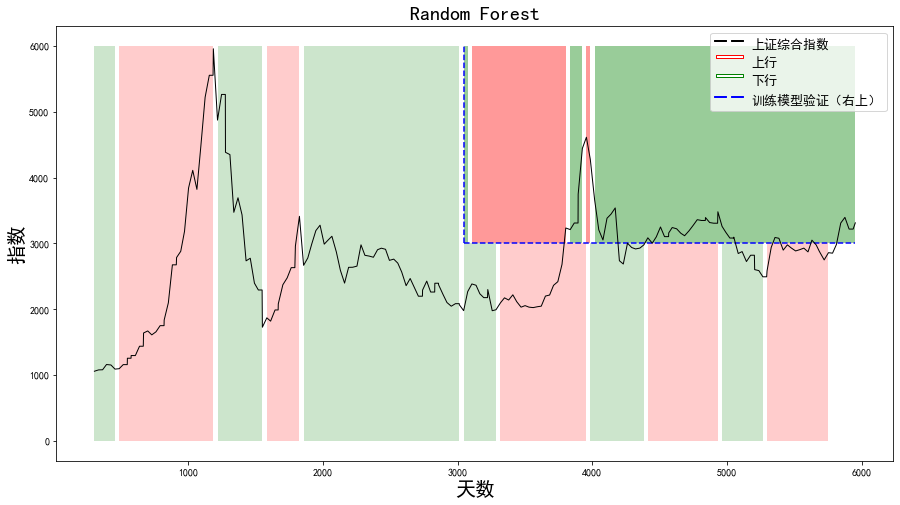

In [4]:
rf=RandomForestRegressor(n_estimators = 1000)
rf.fit(train_x, train_y)
rf_prd = rf.predict(valid_x)

lvl = np.mean(rf_prd) * 0

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('Random Forest',fontproperties='SimHei', size = 20)
ax.plot(d8, [i[0] for i in df], color='black', linewidth = 1, label = '上证综合指数')

plt.xlabel(u'天数',fontproperties='SimHei',fontsize = 20)
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

h = 3000

r_al = .2
p_al = .4

collection = collections.BrokenBarHCollection.span_where(
    d8[int(len(x)*r):], ymin=h, ymax=6000, where=np.array(rf_prd) >= lvl, facecolor='red', alpha= p_al, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[int(len(x)*r):], ymin=h, ymax=6000, where=np.array(rf_prd) < lvl, facecolor='green', alpha= p_al, label = '下行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[int(len(x)*r):], ymin=0, ymax=h, where=np.array(valid_y) == 1, facecolor='red', alpha= r_al)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[int(len(x)*r):], ymin=0, ymax=h, where=np.array(valid_y) == -1, facecolor='green', alpha= r_al)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[:int(len(x)*r)], ymin=0, ymax=6000, where=np.array(train_y) == 1, facecolor='red', alpha= r_al)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8[:int(len(x)*r)], ymin=0, ymax=6000, where=np.array(train_y) == -1, facecolor='green', alpha= r_al)
ax.add_collection(collection)

plt.vlines(d8[int(len(x)*r)], h, 6000, ls="--",color="blue", label = '训练模型验证（右上）')
plt.hlines(h, d8[int(len(x)*r)], d8[-1], ls="--",color="blue")

new_legends = ["--", "-",'-','--']
markers = ['--', '-','-','--']
colors = ['black', 'red', 'green','blue']

_, labels = ax.get_legend_handles_labels()

def dupe_legend(label, color):
    line = Line2D([0], [0], linestyle='none', mfc= 'white',
                mec=color, marker=r'$\mathregular{{{}}}$'.format(label))
    return line

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

plt.show()

# 马丁·普林格

In [5]:
def pring(b,s,c):
    if b == 1 and s == c == -1:
        return 1
    if b == s == 1 and c == -1:
        return 2
    if b == s == c == 1:
        return 3
    if b == -1 and s == c == 1:
        return 4
    if b == s == -1 and c == 1:
        return 5
    if b == s == c == -1:
        return 6
    else:
        return 0

In [6]:
all_ud = []

for j in range(len(data)):
    dfp = deepcopy(data[j])
    cd = 6
    slow = 24
    i = 0
    udj = []

    while i+slow < len(dfp):

        if i == len(dfp) - 1:
            ud[-1] = udj[-2]
            break

        cur = dfp[i]
        next_id = min([dfp.index(max(dfp[i+1+cd:i+1+slow])), (dfp).index(min(dfp[i+1+cd:i+1+slow]))])
        udj[i:next_id+1] = [- (-1) ** (dfp[next_id] > dfp[i])] * (next_id + 1 - i)
        i = next_id
    all_ud.append(udj)
    
pring_res = []
for i in range(len(all_ud[2])):
    pring_res.append(pring(all_ud[2][i],all_ud[0][i],all_ud[1][i]))


# 绝对KST

In [7]:
#ROCSMA变化率移动平均

def rocsma(d1,i1,l_roc,l_sma):
    res = 0
    for x in range(l_sma):
        res += (d1[i1-x-1]/d1[i1-x-l_sma-1]-1)/l_sma
    return res

#KST公式

def kst(d2,i2,roc_l1,roc_l2,roc_l3,roc_l4,sma_l1,sma_l2,sma_l3,sma_l4,sig_l):
    
    k = 0
    for x in range(sig_l):
        rocma1 = rocsma(d2,i2-x,roc_l1,sma_l1)
        rocma2 = rocsma(d2,i2-x,roc_l2,sma_l2)
        rocma3 = rocsma(d2,i2-x,roc_l3,sma_l3)
        rocma4 = rocsma(d2,i2-x,roc_l4,sma_l4)
        k += (rocma1 * 1 + rocma2 * 2 + rocma3 * 3 + rocma4 * 4)/sig_l 
    return k

mkst = []
for i in range(42,len(data[0])):
    mkst.append(kst(data[0],i,9,12,18,24,6,6,6,9,9))

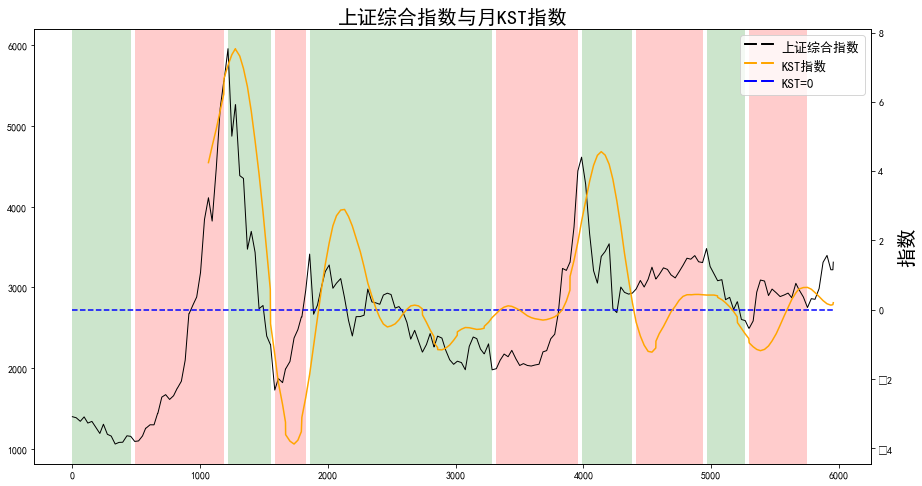

In [8]:
d8a = []
for i in range(len(date)):
    d8a.append(int((date[i] - date[0]).days))

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('上证综合指数与月KST指数',fontproperties='SimHei', size = 20)
ax.plot(d8a, data[0], color='black', linewidth = 1, label = '上证综合指数')

ax2 = ax.twinx()
ax2.plot(d8a[42:], mkst, color='orange', linewidth = 1.5, label = 'KST指数')

plt.hlines(0, d8a[0], d8a[-1], ls="--",color="blue", label = 'KST=0')

plt.xlabel(u'天数',fontproperties='SimHei',fontsize = 20)
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
    d8a, ymin=-4000, ymax=8000, where=np.array(ud) == 1, facecolor='red', alpha= r_al, label = 'KST指数')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    d8a, ymin=-4000, ymax=8000, where=np.array(ud) == -1, facecolor='green', alpha= r_al, label = 'KST=0')
ax.add_collection(collection)


new_legends = ["--", "--","--",'-','-']
markers = ['--', '--',"--",'-','-']
colors = ['black', 'orange','blue','red', 'green']



_, labels = ax.get_legend_handles_labels()

def dupe_legend(label, color):
    line = Line2D([0], [0], linestyle='none', mfc= 'white',
                mec=color, marker=r'$\mathregular{{{}}}$'.format(label))
    return line

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)


plt.show()


# 证券/商品市场相对强度